In [3]:
import sys
from pathlib import Path

exp_dir = str(Path("..").resolve())
if exp_dir not in sys.path:
    sys.path.insert(0, exp_dir)

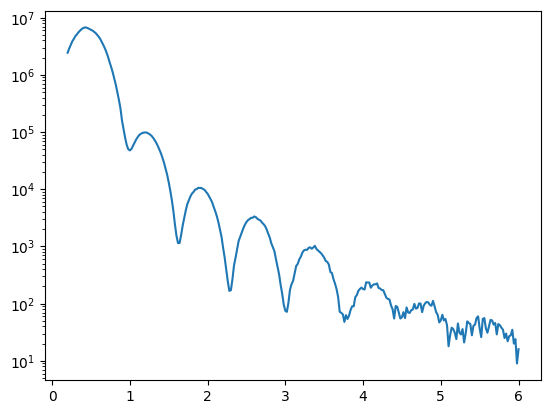

In [4]:
import matplotlib.pyplot as plt

from reflecto.io_utils import load_xrr_dat
from reflecto.physics_utils import tth2q
from reflecto.simulate.simul_genx import ParamSet, param2refl

data_file = Path(r"D:\03_Resources\Data\XRR_AI\XRR_data\XRR_data2\#1.dat")
weights_path = Path(r"D:\03_Resources\Data\XRR_AI\data\one_layer\power0_95_tune")
# weights_path = Path(r"D:\03_Resources\Data\XRR_AI\data\one_layer\1000q_2")

tths, R_raw = load_xrr_dat(data_file)
q_raw = tth2q(tths)
plt.plot(tths, R_raw)
plt.yscale("log")

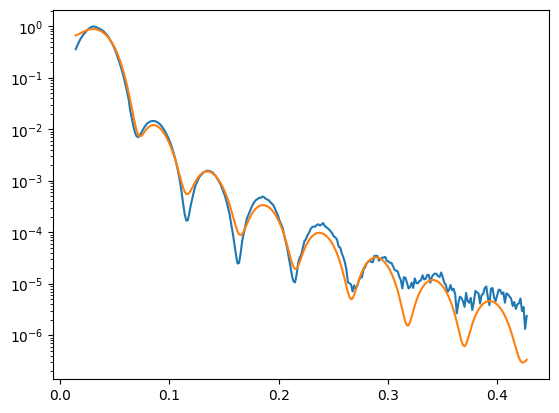

In [5]:
from reflecto.math_utils import powerspace


param = ParamSet(120, 4, 41)
sim_refl = param2refl(q_raw, [param])

plt.plot(q_raw, R_raw / R_raw.max())
plt.plot(q_raw, sim_refl)
plt.yscale("log")

[Inference] Device: cuda
[Inference] Grid Generation: Power=0.95, Points=1000
[Inference] Model loaded from D:\03_Resources\Data\XRR_AI\data\one_layer\power0_95_tune\best.pt
>>> NN Prediction:
Thickness : 21.53 Å
Roughness : 2.85 Å
SLD : 5.119 (10⁻⁶ Å⁻²)


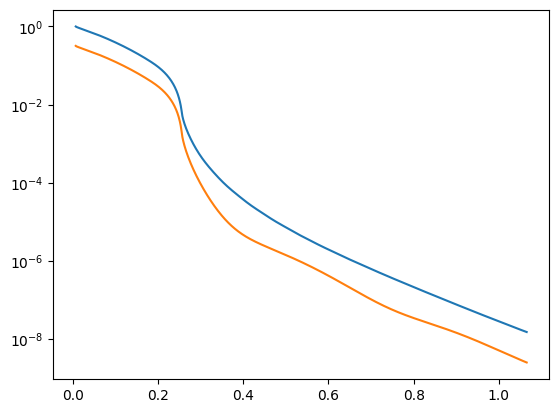

In [6]:
from fitting_engine import GenXFitter
from inference import XRRInferenceEngine

from reflecto.math_utils import powerspace
powerq = powerspace(tth2q(0.1), tth2q(15), 1000, 1.5)
param = ParamSet(150, 2, 20)
sim_refl = param2refl(powerq, [param])

inference_engine = XRRInferenceEngine(exp_dir=weights_path)

pred_d, pred_sig, pred_sld = inference_engine.predict(powerq, sim_refl)


print(">>> NN Prediction:")
print(f"Thickness : {pred_d:.2f} Å")
print(f"Roughness : {pred_sig:.2f} Å")
print(f"SLD : {pred_sld:.3f} (10⁻⁶ Å⁻²)")

param = ParamSet(pred_d, pred_sig, pred_sld)
new_sim_refl = param2refl(powerq, [param])

plt.plot(powerq, sim_refl / sim_refl.max())
plt.plot(powerq, new_sim_refl)
plt.yscale("log")

[Inference] Device: cuda
[Inference] Grid Generation: Power=0.95, Points=1000
[Inference] Model loaded from D:\03_Resources\Data\XRR_AI\data\one_layer\power0_95_tune\best.pt
>>> NN Prediction:
Thickness : 100.90 Å
Roughness : 5.29 Å
SLD : 21.437 (10⁻⁶ Å⁻²)


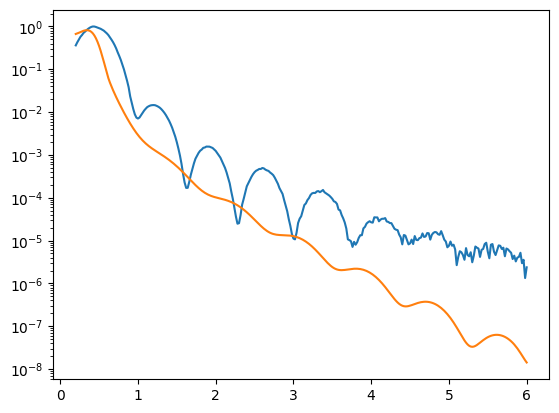

In [7]:
inference_engine = XRRInferenceEngine(exp_dir=weights_path)

pred_d, pred_sig, pred_sld = inference_engine.predict(q_raw, R_raw)


print(">>> NN Prediction:")
print(f"Thickness : {pred_d:.2f} Å")
print(f"Roughness : {pred_sig:.2f} Å")
print(f"SLD : {pred_sld:.3f} (10⁻⁶ Å⁻²)")

param = ParamSet(pred_d, pred_sig, pred_sld)
sim_refl = param2refl(q_raw, [param])

plt.plot(tths, R_raw / R_raw.max())
plt.plot(tths, sim_refl)
plt.yscale("log")


[GenX] Step 1: Fitting I0 & Sample Length...
  -> I0: 2.180, Sample Len: 5.83 mm
[GenX] Step 2: Fitting All Params (Log)...

----------------------------------------
FINAL ANALYSIS RESULT
----------------------------------------
set_f_d        : 107.3412
set_f_sig      : 12.8233
set_f_sld      : 35.8138
set_s_d        : 11.8258
set_s_sig      : 1.7973
set_s_sld      : 23.0000
set_i0         : 2.0675
set_s_len      : 37.5414


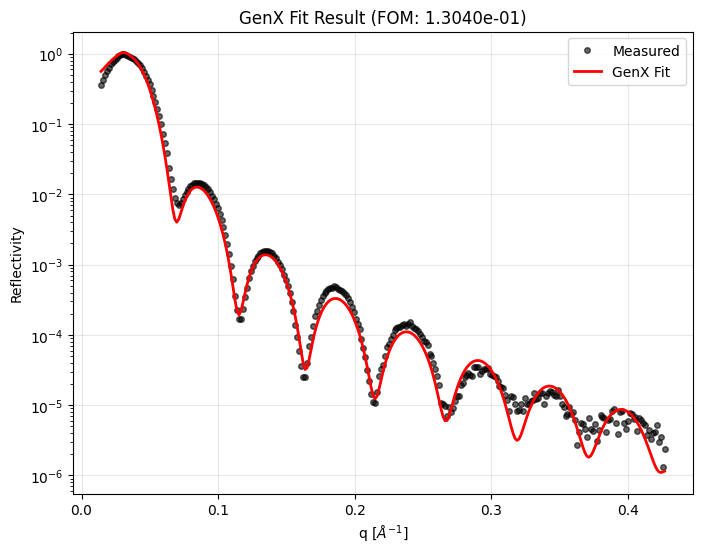

nn_preds: (np.float32(100.904526), np.float32(5.2936487), np.float32(21.437208))
final_params: {'set_f_d': 107.34122438478327, 'set_f_sig': 12.823338144162191, 'set_f_sld': 35.81378746958295, 'set_s_d': 11.825772702676566, 'set_s_sig': 1.7972863263557393, 'set_s_sld': 22.99999999983514, 'set_i0': 2.0674867850855994, 'set_s_len': 37.54140156955969}
fitter: <fitting_engine.GenXFitter object at 0x000002D334C25EB0>


In [8]:
nn_initial_params = ParamSet(pred_d, pred_sig, pred_sld)
nn_initial_params = ParamSet(120, 4, 41)
fitter = GenXFitter(q_raw, R_raw, nn_initial_params)

# 피팅 실행
final_results = fitter.run(verbose=True)
    # ---------------------------------------------------------

print("\n" + "-"*40)
print("FINAL ANALYSIS RESULT")
print("-"*40)
for param_name, value in final_results.items():
    print(f"{param_name:15s}: {value:.4f}")
print("="*40)


fitter.plot()

# 결과 반환
result = {
"nn_preds": (pred_d, pred_sig, pred_sld),
"final_params": final_results,
"fitter": fitter,
}

for key, val in result.items():
    print(f"{key}: {val}")

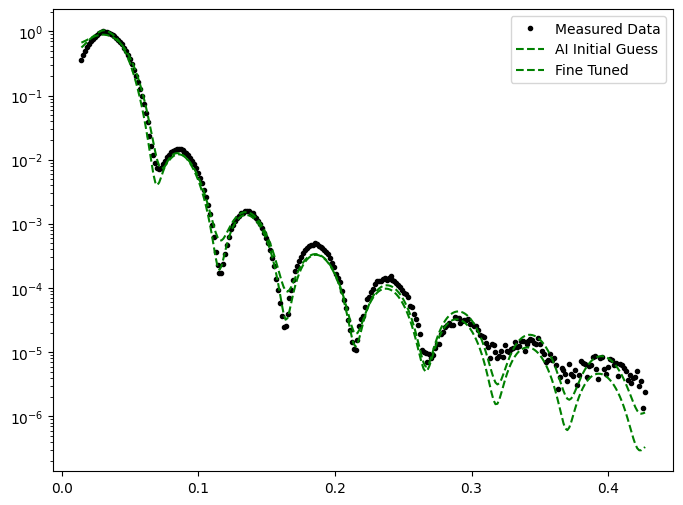

In [9]:
param = ParamSet(120, 4, 41)
sim_refl = param2refl(q_raw, [param])
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(q_raw, R_raw / R_raw.max(), "k.", label="Measured Data")
ax.plot(q_raw, sim_refl, "g--", label="AI Initial Guess")
ax.plot(q_raw, fitter.R_sim, "g--", label="Fine Tuned")
ax.legend()
ax.set_yscale("log")

In [10]:
# from inference_pipeline import run_xrr_analysis

# data_root = Path(r"D:\03_Resources\Data\XRR_AI\XRR_data\XRR_data")
# weights_path = Path(r"D:\03_Resources\Data\XRR_AI\data\one_layer\sio2_random2")
# inference_engine = XRRInferenceEngine(exp_dir=weights_path)

# for dat_file in data_root.glob("*.dat"):
#     print(dat_file.name)
#     run_xrr_analysis(dat_file, weights_path, inference_engine, verbose=False, show_plot=True)